<a href="https://colab.research.google.com/github/LuizaGomes03/2TIAF---Software/blob/main/Copy_of_CP1_Visao_Computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diagóstico de Pneumonia por imagem

![]( https://conteudo.imguol.com.br/c/entretenimento/6e/2020/07/11/radiografia-pulmao-raio-x-1594480928712_v2_1133x926.jpg)

## Contexto

A radiografia de tórax normal (painel esquerdo) mostra pulmões limpos, sem áreas de opacificação anormal na imagem. A pneumonia bacteriana (meio) normalmente exibe uma consolidação lobar focal, neste caso no lobo superior direito (setas brancas), enquanto a pneumonia viral (direita) se manifesta com um padrão “intersticial” mais difuso em ambos os pulmões.

![](https://www.cell.com/cms/attachment/538d3845-028b-4666-af36-7fba78c5c774/figs6.jpg)

## Sobre os dados

O conjunto de dados é organizado em 3 pastas (train, test, val) e contém subpastas para cada categoria de imagem (Pneumonia/Normal). São 5.863 imagens de Raios X (JPEG) e 2 categorias (Pneumonia/Normal).

Imagens de radiografia de tórax (ântero-posterior) foram selecionadas de pacientes pediátricos de um a cinco anos de idade do Centro Médico Feminino e Infantil de Guangzhou, Guangzhou. Todas as radiografias de tórax foram realizadas como parte do atendimento clínico de rotina dos pacientes.

Para a análise das imagens de radiografia de tórax, todas as radiografias de tórax foram inicialmente examinadas para controle de qualidade, removendo todos os exames de baixa qualidade ou ilegíveis. Os diagnósticos das imagens foram então avaliados por dois médicos especialistas antes de serem liberados para o treinamento do sistema de IA. Para compensar eventuais erros de classificação, o conjunto de avaliação também foi verificado por um terceiro especialista.


## Desafio

Neste desafio, você foi selecionado para desenvolver um sistema de diagnóstico automático de Pneumonia a partir de imagens de Radiografias de pacientes de um hostpital. Siga as instruções deste Notebook até atingir o seu seu objetivo final: Uma Rede Neural Convolucional para classificar as imagens em duas classes: Pneumonia e Normal. Boa sorte! 🖖  

In [ ]:
# Importando as bibliotecas necessárias
import numpy as np
import cv2
import matplotlib.pyplot as plt
from urllib.request import urlopen
from PIL import Image
from google.colab.patches import cv2_imshow
import os
from tqdm import tqdm
import pandas as pd
import shutil

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist, cifar10 #this library contains a lot of ML datasets including the MNIST one
import pickle #pickle is a library that helps us save a lot of different types of data - anything ranging from Pandas dataframes to TensorFlow models
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Conv3D, MaxPooling3D, Input
from tensorflow.keras import Sequential, optimizers, Model, utils
from tensorflow.keras.activations import sigmoid
from sklearn import metrics
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(2))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

## Carregando o dataset

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [ ]:
#contando quantas imagens temos de pessoas com Pneumonia e sem pneumonia
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


In [ ]:
#codificando os labels em 0 e 1
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    if parts[-2] == "PNEUMONIA":
        return 1
    else:
        return 0


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
#dividindo os dados em treino e validação.
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

In [ ]:
#visualizando o shape das imagens
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


In [ ]:
#carregando e formatando os dados de teste
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

## Visuaizando algumas amostras de imagens

In [ ]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [ ]:
label_batch

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
      dtype=int32)>

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

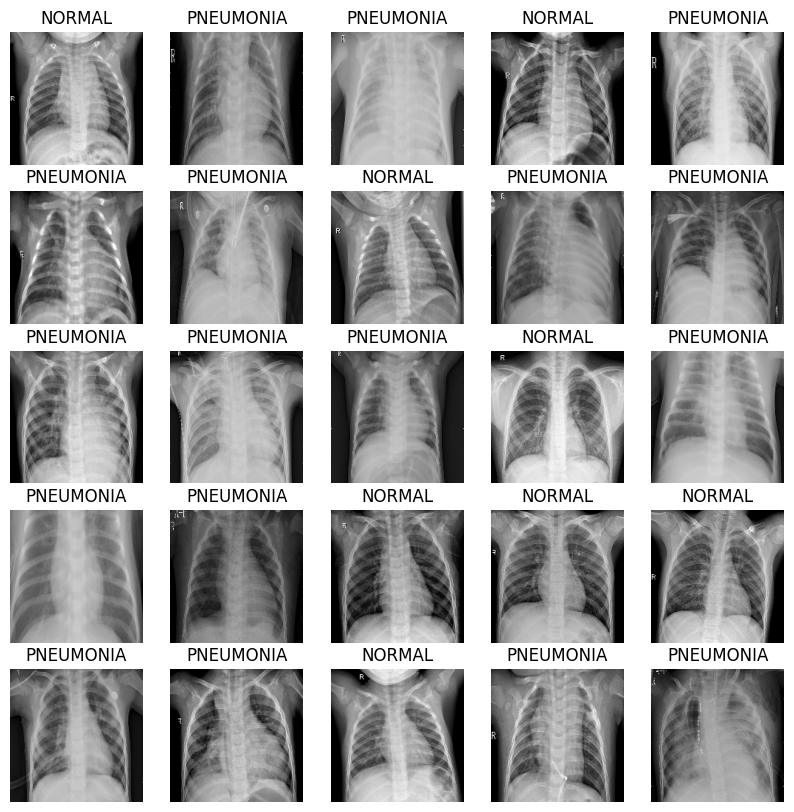

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Criando um modelo de CNN

In [ ]:
model = Sequential()
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))# Input layer
model.add(Conv2D(16, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2))) # downsizing images
model.add(Flatten()) # images are 3d so have to flatten them into a (1 x 784) vector
model.add(Dense(256, activation=tf.nn.relu, use_bias=True)) # adding a Dense layer of 128 neurons with relu
model.add(Dropout(0.2)) #Implementing dropout regularization with p = 0.5
model.add(Dense(128, activation=tf.nn.relu, use_bias=True))
model.add(Dropout(0.1))
model.add(Dense(64, activation=tf.nn.relu, use_bias=True))
model.add(Dropout(0.1))
model.add(Dense(1,activation=tf.nn.sigmoid)) # adding an output layer (with 10 possible outputs for the 10 digits we need to predict)

In [ ]:
early_stopping_cb = EarlyStopping(
    patience=10, restore_best_weights=True
)
optimizer=Adam(learning_rate=0.01)
METRICS = [
        BinaryAccuracy(),
        Precision(name="precision"),
        Recall(name="recall"),
    ]

In [ ]:
# compilando o modelo
model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=METRICS,
    )

In [ ]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping_cb],
)

##Lucas Matheus -> RM: 550466
## Luiza Gomes -> RM: 97797
## Raphael Rodrigues -> RM: 552432

## 1- Adicione mais camadas convolucionais e responda as seguintes questões:

a) O modelo melhorou ou piorou? Por quê?

b) Compare as curvas de aprendizado deste modelo com o modelo treinado anteriormente

c) Na sua opinião, este modelo está bom ou pode ser melhorado? Caso ele possa ser melhorado, apresente sugestões para melhorá-lo.

1)
a) O modelo melhorou porque tem ele tem menos perda de validação e mais acurácia


b) O segundo modelo mehorou em relação ao primeiro pois está melhor treinando



c) Pode ser melhorado pois o modelo começa a apresentar overfitting

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Defina as dimensões da imagem de entrada
img_height = 128
img_width = 128

# Defina a arquitetura do modelo
model = Sequential()

# Adicione camadas convolucionais
model.add(Conv2D(16, 3, activation="relu", padding="same", input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) # downsizing images
model.add(Conv2D(32, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2))) # downsizing images
model.add(Conv2D(64, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2))) # downsizing images

# Adicione camadas densas/classificadoras
model.add(Flatten()) # images are 3d so have to flatten them into a (1 x 784) vector
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
import tensorflow as tf

# Redimensionar imagens para o tamanho esperado pelo modelo
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, (img_height, img_width)), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, (img_height, img_width)), y))


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Defina o callback de parada antecipada
early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True)

# Compile o modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Treine o modelo
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping_cb]
)


Epoch 1/10
66/66 [==============================] - 6s 46ms/step - loss: 3.5111 - accuracy: 0.8376 - val_loss: 0.1079 - val_accuracy: 0.9583
Epoch 2/10
66/66 [==============================] - 2s 29ms/step - loss: 0.1635 - accuracy: 0.9405 - val_loss: 0.0928 - val_accuracy: 0.9661
Epoch 3/10
66/66 [==============================] - 3s 44ms/step - loss: 0.1072 - accuracy: 0.9607 - val_loss: 0.0527 - val_accuracy: 0.9806
Epoch 4/10
66/66 [==============================] - 2s 29ms/step - loss: 0.0809 - accuracy: 0.9695 - val_loss: 0.0538 - val_accuracy: 0.9767
Epoch 5/10
66/66 [==============================] - 2s 29ms/step - loss: 0.0693 - accuracy: 0.9767 - val_loss: 0.0727 - val_accuracy: 0.9729
Epoch 6/10
66/66 [==============================] - 2s 28ms/step - loss: 0.0973 - accuracy: 0.9645 - val_loss: 0.0563 - val_accuracy: 0.9767


In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

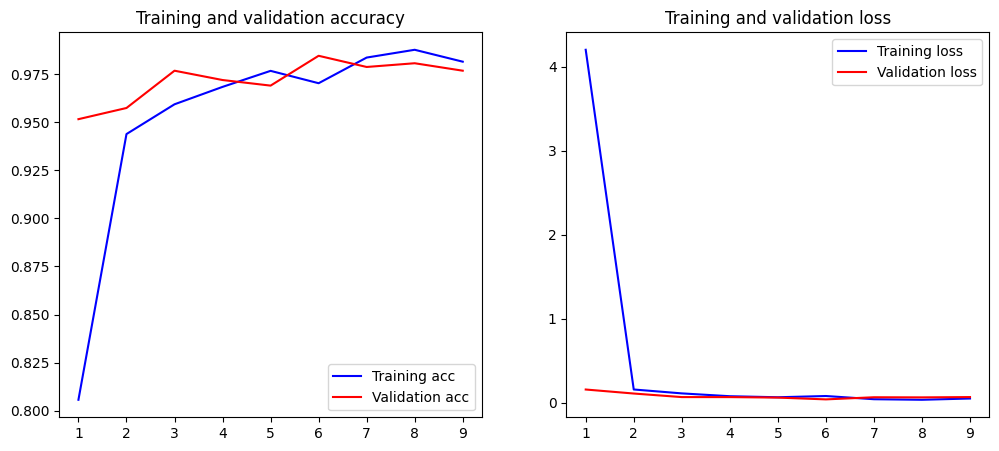

In [ ]:
plot_history(history)

## 2- Visualize o resultado dos filtros aprendidos pela última camada convolucional do seu modelo aplicando-o em algumas imagens. Apresente a sua interpretação dos resultados


In [ ]:
# pegando os pesos da primeira camada conv
filters , bias = model.layers[0].get_weights()

In [ ]:
filters.shape

(3, 3, 3, 16)

In [ ]:
filters[:,:,0,0]

array([[ 0.0908465 , -0.02288137,  0.11253094],
       [ 0.17737955, -0.18620259,  0.17690521],
       [ 0.08937338, -0.16525611, -0.02180258]], dtype=float32)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)       

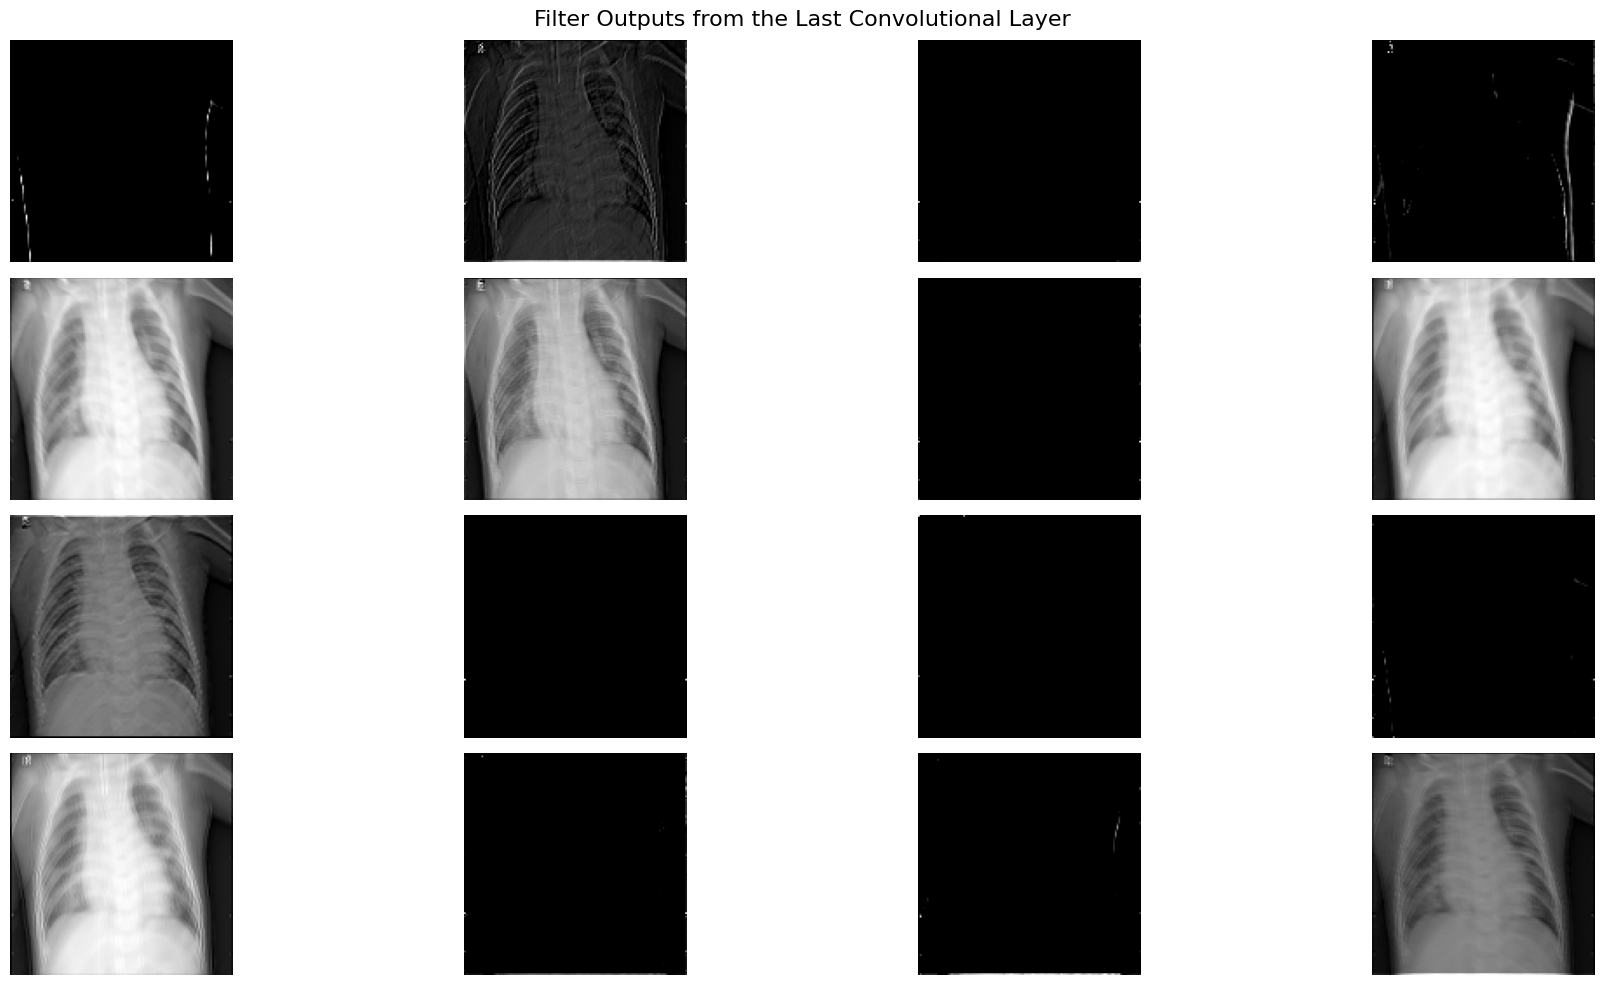

In [ ]:
from tensorflow.keras import models

# Create a new model that includes only the convolutional layers
conv_model = models.Model(inputs=model.input, outputs=model.get_layer(index=0).output)

# Choose an input image from the dataset
img = next(iter(val_ds))[0][0]  # Get the first image from the validation dataset

# Preprocess the input image
img = tf.image.resize(img, (img_height, img_width))  # Resize the image to the expected input size
img = tf.expand_dims(img, axis=0)  # Add a batch dimension

# Get the filter outputs
filter_outputs = conv_model(img)

# Plot the filter outputs
import matplotlib.pyplot as plt
import numpy as np

# Define the number of filters in the last convolutional layer
num_filters = filter_outputs.shape[-1]

# Create a grid of subplots
rows = 4
cols = int( np.ceil(num_filters / rows))
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))

# Plot each filter output
for i, ax in enumerate(axs.flat):
    if i < num_filters:
        ax.imshow(filter_outputs[0, :, :, i], cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')

plt.suptitle('Filter Outputs from the Last Convolutional Layer', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
img_height, img_width

(128, 128)

2) É possivel identificar difrenets partes na imagem com diferentes filtros, acarretando em um dificulade de identificção dos sintomas da doença.


##3- Faça um gráfico com a matriz de confusão para o dataset de teste e responda a seguinte pergunta: É seguro utilizar este modelo para substituir um diagnóstico feito por um médico humano? Apresente sugestões de como o médico/hospital poderia utilizá-lo de forma segura no seu dia-a-dia.

In [ ]:
from tensorflow.keras.layers import Flatten

# Define the input image dimensions
img_height = 180
img_width = 180

# Define the model architecture
model = Sequential()

# Add convolutional layers
model.add(Conv2D(16, 3, activation="relu", padding="same", input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the Flatten layer
model.add(Flatten())

# Add dense/classifier layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load and preprocess the test dataset
test_images = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec")
test_paths = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec")
test_ds = tf.data.Dataset.zip((test_images, test_paths))
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

10/10 [==============================] - 6s 405ms/step - loss: 30.7028 - accuracy: 0.3750
Test Loss: 30.7028, Test Accuracy: 0.3750


In [ ]:
# Load and preprocess the test dataset
test_images = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec")
test_paths = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec")
test_ds = tf.data.Dataset.zip((test_images, test_paths))
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

10/10 [==============================] - 8s 594ms/step


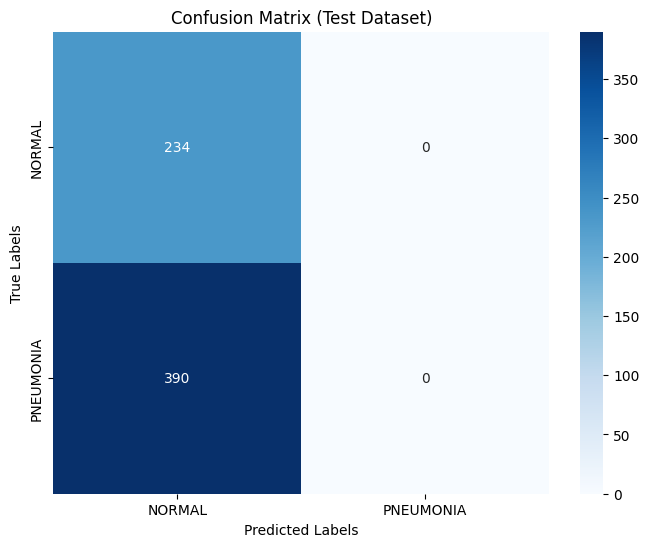

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions on the test dataset
y_pred = model.predict(test_ds)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Get true labels from the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix (Test Dataset)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

3) Não é seguro utilizar este modelo para substituir um diagnóstico feito por um médico humano pois o modelo apresenta muitos falso negativo levando a uma demora no atendimento de prevenção a doença, porem em um modelo bem avaliado isso pode facilitar um diagnostico, com diferentes filtros  permitindo uma obsevação mais "precisa" de um Raio-X.  
